# Exercise 7 - Approximating the Sine function
## Task
Approximate the sine function with a fully connected neural network using PyTorch.

Subtasks:
- Change the neural network architecture to a single hidden layer with two neurons.
  - What do you observe?
- Increase the number of neurons per layer and the number of layers. Try, e.g., [2] and [50,50]. What do you observe?
  - Name ways to overcome this problem.
- Take a look at the cost function history. At what epoch should the algorithm stop to prevent overfitting?
- Set the learning rate to α = 0.1. What do you observe?
- Reset the learning rate to α = 0.001 and set λ > 0 where the model fits the sine curve without overfitting.
- Increase λ until underfitting occurs and plot the result.
- Change the model to use ReLU activation function and plot the result.
- Why does the neural network not learn the sine function properly at the boundaries (and beyond the boundaries)?

## Learning Goals
- Get an understanding of the code and introduction to model training.
- Influence of hyperparameters on model fit - which hyperparameters are the most important?
- Change the non-linear activation function to ReLU instead of Sigmoid.
- Why does the model not learn the sine curve properly at the boundaries? Is there any remedy to this problem? 

___

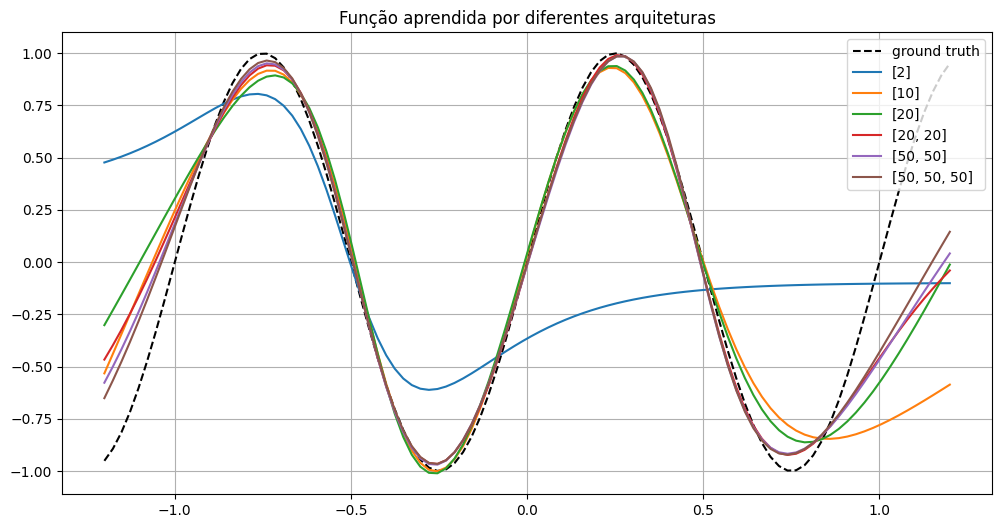

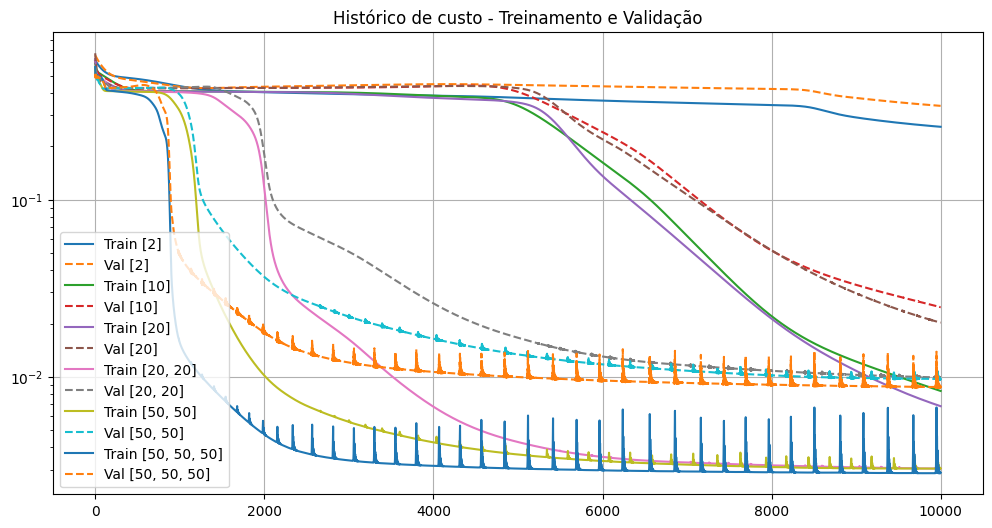

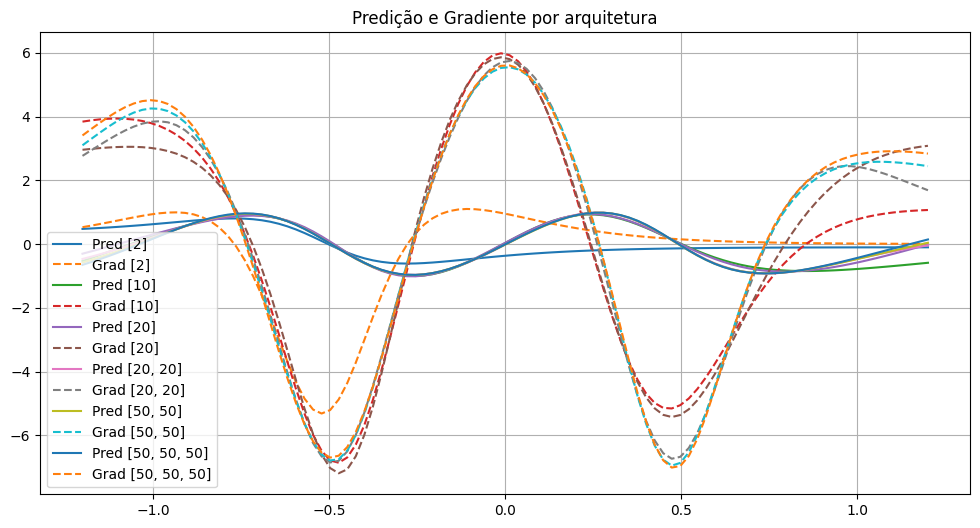

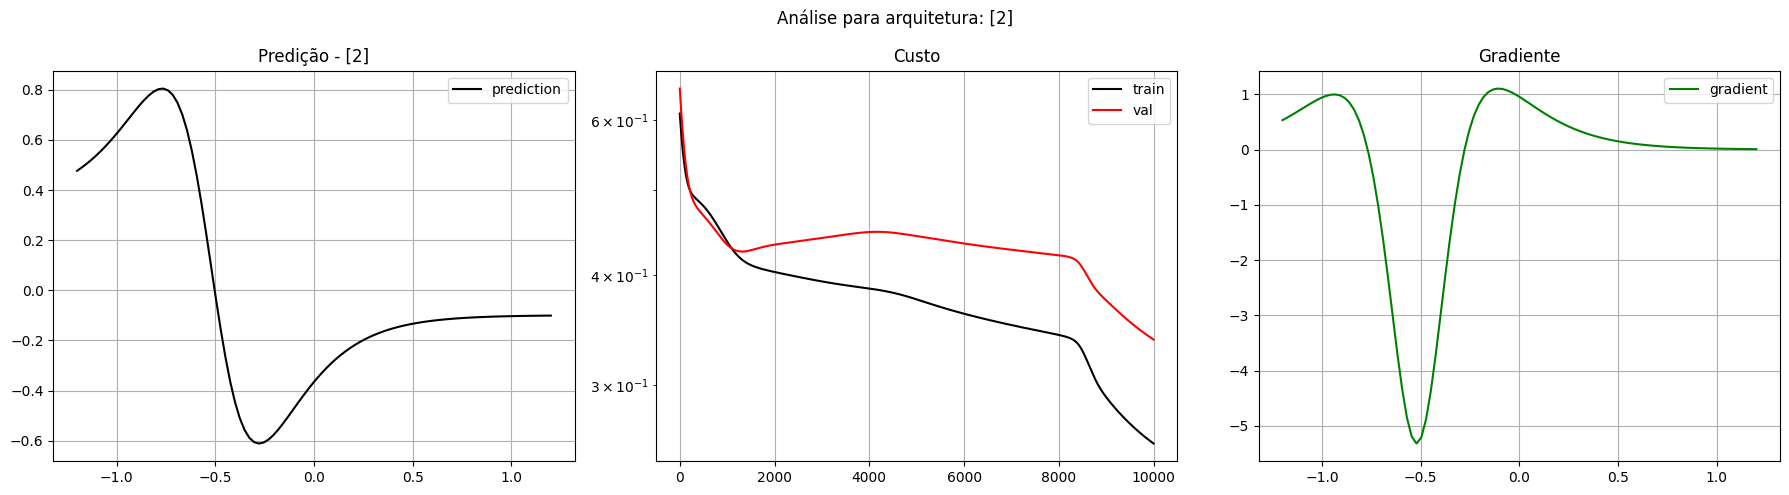

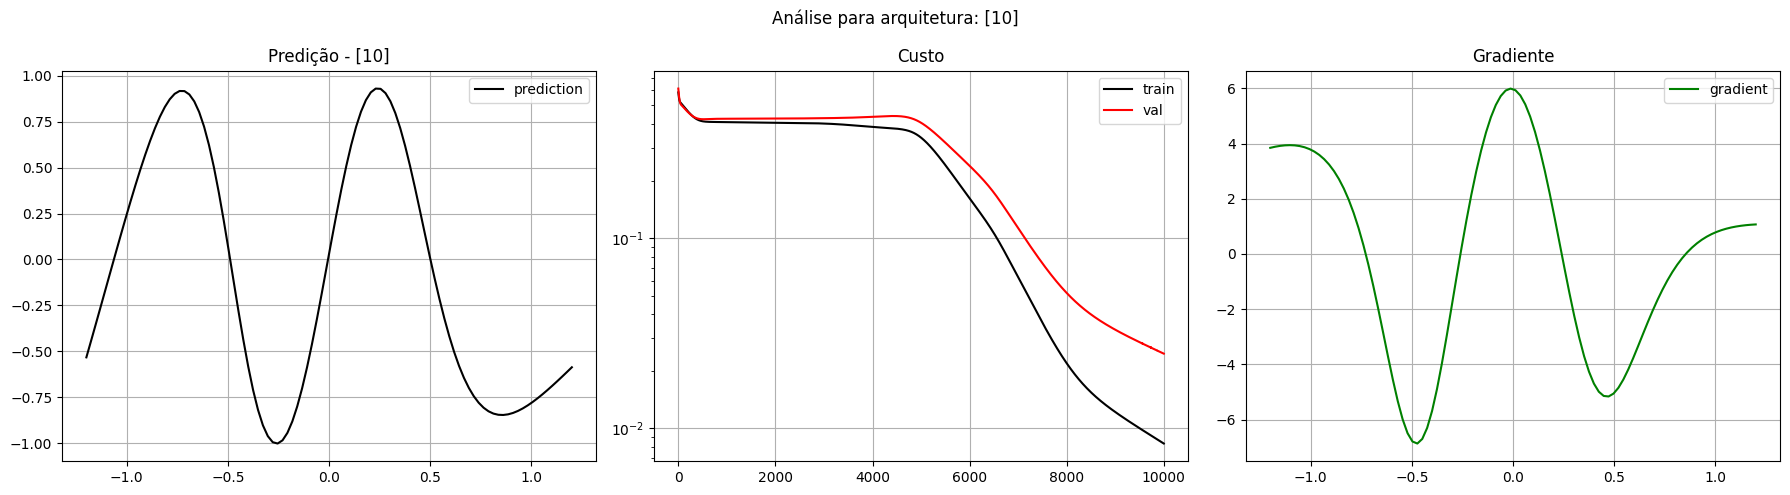

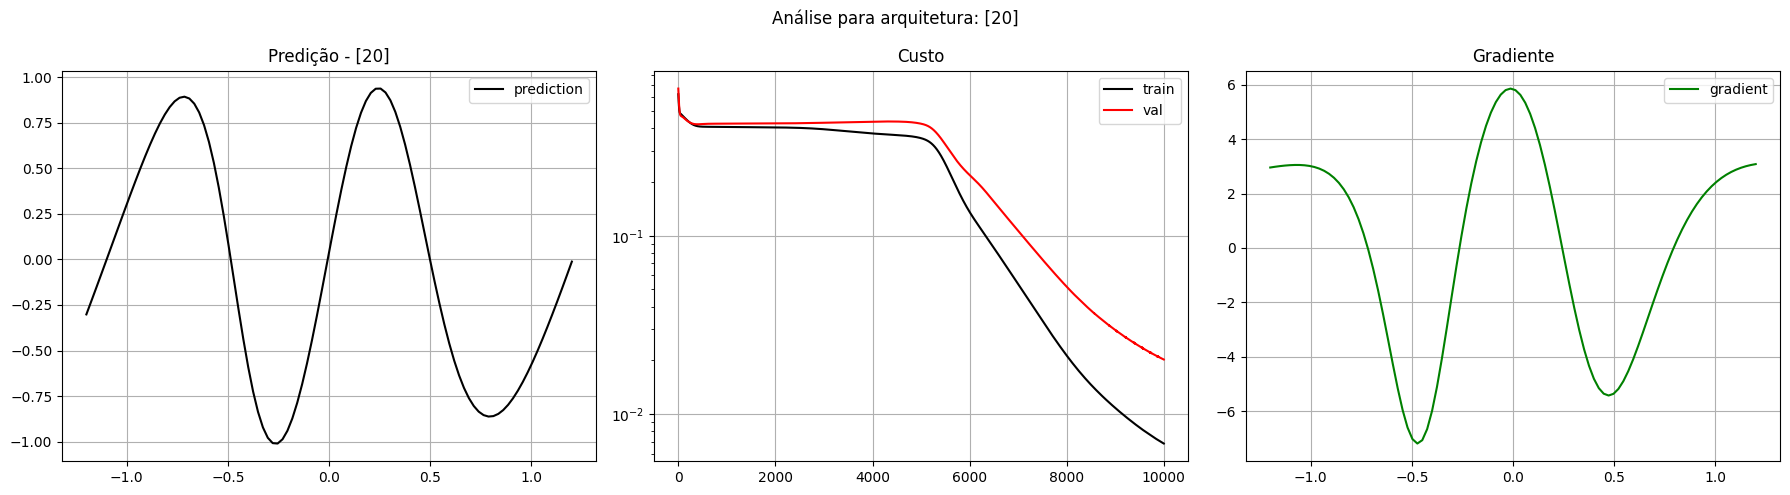

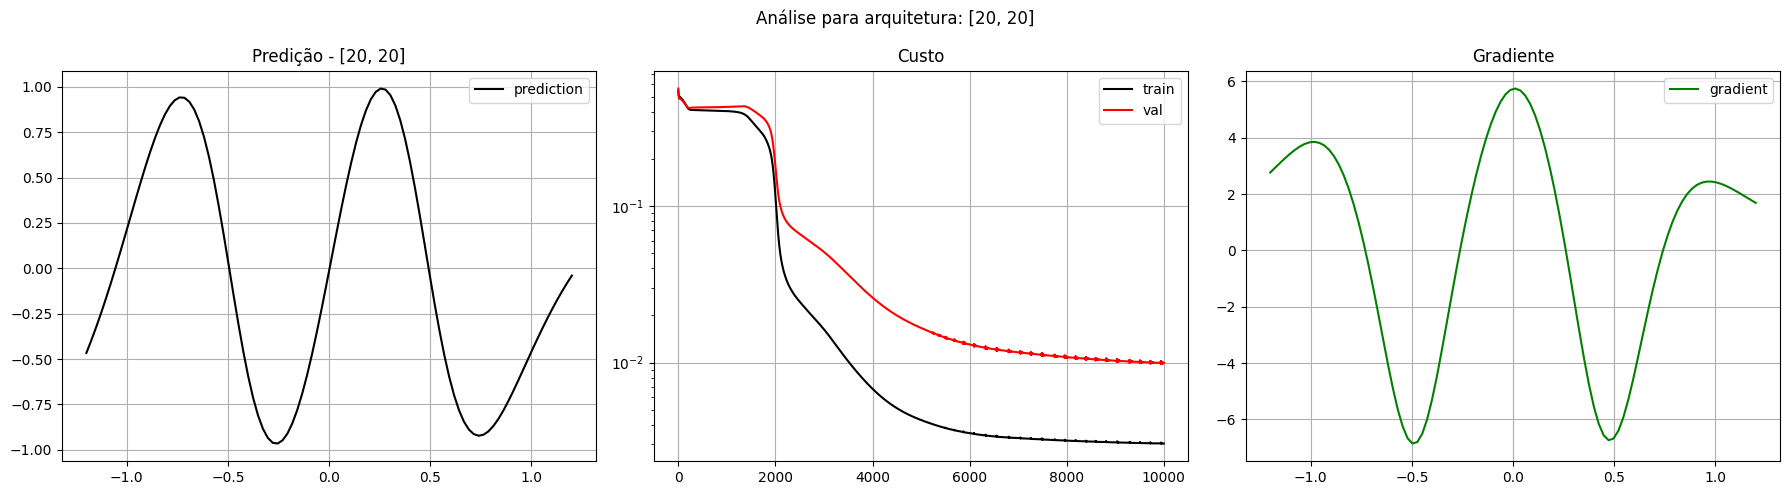

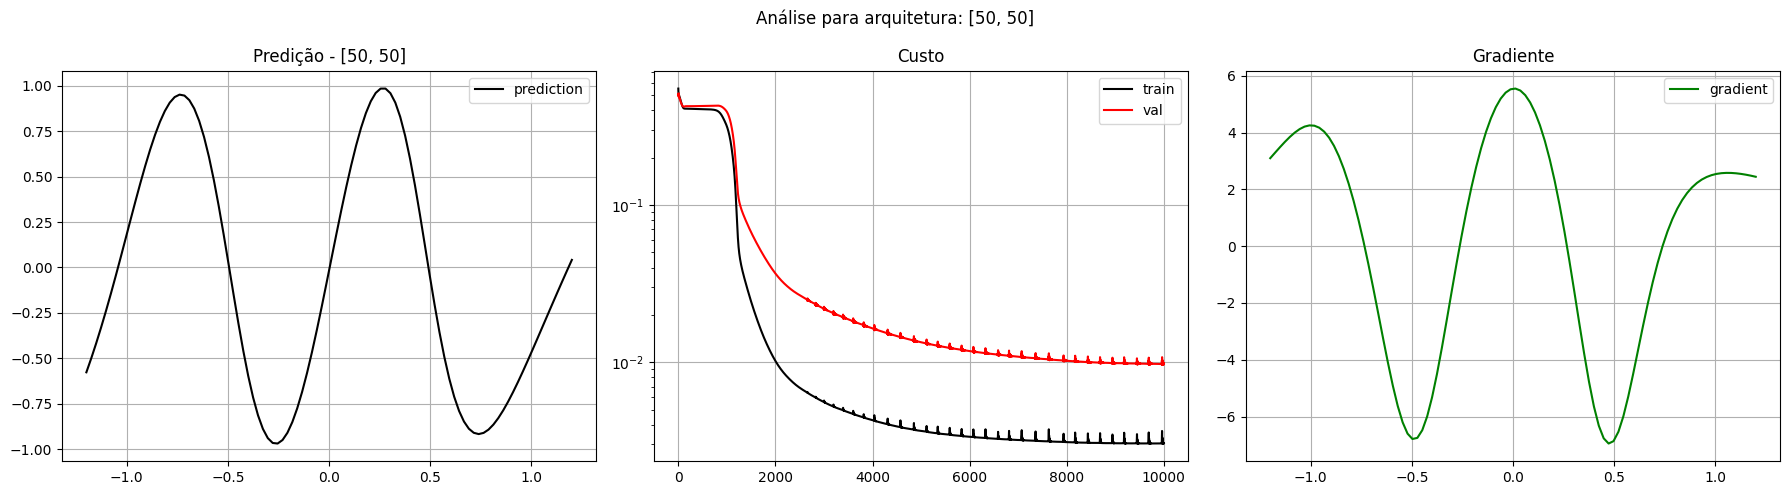

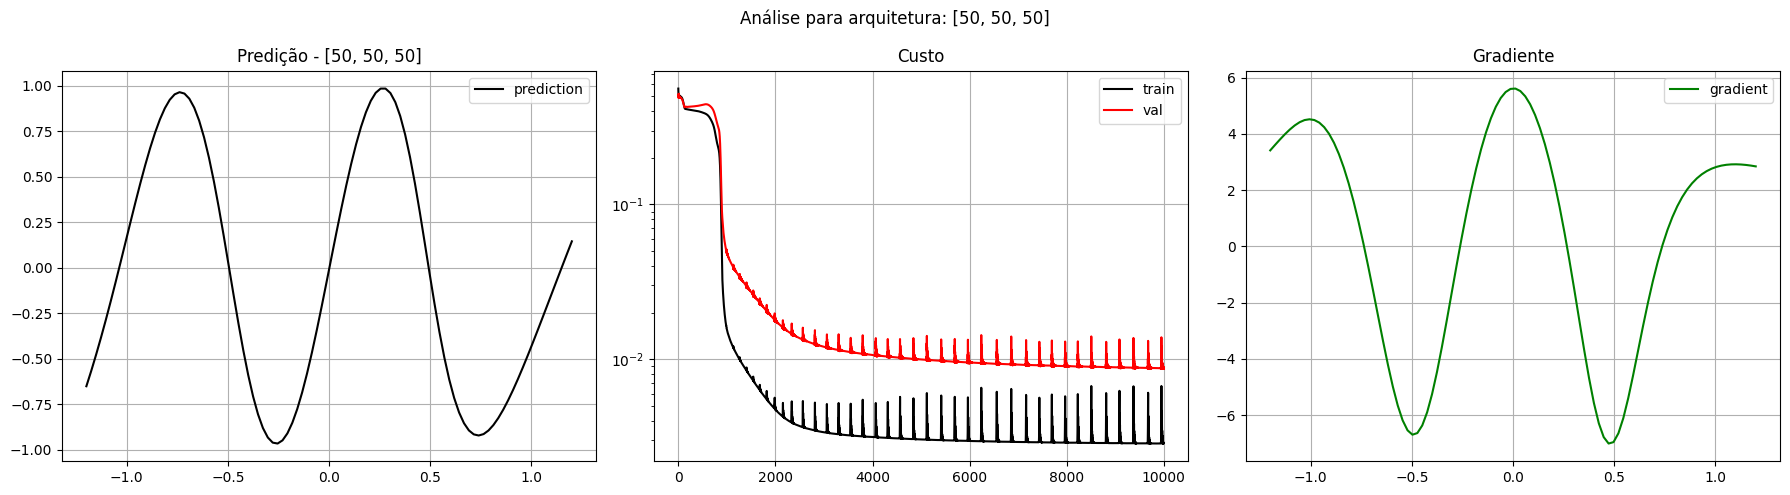

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)

# Função ground truth
f = lambda x: torch.sin(2 * torch.pi * x)

# Dados de treino e teste
numberOfSamples = 40
noise = 0.1

xTrain = torch.rand((numberOfSamples, 1)) * 2 - 1
yTrain = f(xTrain) + noise * (torch.rand(xTrain.shape) * 2 - 1)

xTest = torch.rand((numberOfSamples, 1)) * 2 - 1
yTest = f(xTest) + noise * (torch.rand(xTest.shape) * 2 - 1)

def costFunction(yPred, y):
    return torch.mean((yPred - y) ** 2)

def run_experiment(hiddenDimensions, epochs=10000, lr=1e-3, regularization=1e-4, verbose=True):
    inputDimension = 1
    outputDimension = 1
    nonlinearity = torch.nn.Sigmoid()

    # Modelo
    modules = [torch.nn.Linear(inputDimension, hiddenDimensions[0]), nonlinearity]
    for i in range(len(hiddenDimensions) - 1):
        modules += [torch.nn.Linear(hiddenDimensions[i], hiddenDimensions[i + 1]), nonlinearity]
    modules.append(torch.nn.Linear(hiddenDimensions[-1], outputDimension))
    model = torch.nn.Sequential(*modules)

    optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=regularization)

    costHistoryTrain = np.zeros(epochs)
    costHistoryTest = np.zeros(epochs)

    for epoch in range(epochs):
        optimizer.zero_grad()
        yPred = model(xTrain)
        cost = costFunction(yPred, yTrain)

        with torch.no_grad():
            yPredTest = model(xTest)
            costTest = costFunction(yPredTest, yTest)

        costHistoryTrain[epoch] = cost.detach()
        costHistoryTest[epoch] = costTest.detach()

        cost.backward()
        optimizer.step()

        if verbose and epoch % 1000 == 0:
            print(f"[{hiddenDimensions}] Epoch {epoch}/{epochs}, Train Loss: {cost:.2e}, Test Loss: {costTest:.2e}")

    # Predição
    x = torch.linspace(-1.2, 1.2, 100).unsqueeze(1)
    yPred = model(x).detach()

    # Gradiente
    xGrad = torch.linspace(-1.2, 1.2, 100, requires_grad=True).unsqueeze(1)
    yPredGrad = model(xGrad)
    gradients = torch.autograd.grad(yPredGrad, xGrad, grad_outputs=torch.ones_like(yPredGrad))[0]

    return {
        'hiddenDimensions': hiddenDimensions,
        'x': x.detach().numpy(),
        'yPred': yPred.numpy(),
        'gradients': gradients.detach().numpy(),
        'costHistoryTrain': costHistoryTrain,
        'costHistoryTest': costHistoryTest
    }

# Arquiteturas a testar
experiments = [
    [2],
    [10],
    [20],
    [20, 20],
    [50, 50],
    [50, 50, 50]
]

results = [run_experiment(h, verbose=False) for h in experiments]

# --- GRÁFICO 1: Predição comparada à função verdadeira ---
fig, ax = plt.subplots(figsize=(12, 6))
x_true = torch.linspace(-1.2, 1.2, 100).unsqueeze(1)
y_true = f(x_true).numpy()
ax.plot(x_true, y_true, "k--", label="ground truth")

for res in results:
    label = f"{res['hiddenDimensions']}"
    ax.plot(res['x'], res['yPred'], label=label)

ax.set_title("Função aprendida por diferentes arquiteturas")
ax.legend()
ax.grid()
plt.show()

# --- GRÁFICO 2: Histórico de custo (log scale) ---
fig, ax = plt.subplots(figsize=(12, 6))
for res in results:
    ax.plot(res['costHistoryTrain'], label=f"Train {res['hiddenDimensions']}", linestyle='-')
    ax.plot(res['costHistoryTest'], label=f"Val {res['hiddenDimensions']}", linestyle='--')

ax.set_title("Histórico de custo - Treinamento e Validação")
ax.set_yscale("log")
ax.legend()
ax.grid()
plt.show()

# --- GRÁFICO 3: Predição + Gradientes ---
fig, ax = plt.subplots(figsize=(12, 6))

for res in results:
    ax.plot(res['x'], res['yPred'], label=f"Pred {res['hiddenDimensions']}", linestyle='-')
    ax.plot(res['x'], res['gradients'], label=f"Grad {res['hiddenDimensions']}", linestyle='--')

ax.set_title("Predição e Gradiente por arquitetura")
ax.legend()
ax.grid()
plt.show()

# --- (Opcional) Gráficos individuais por arquitetura ---
for res in results:
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    x = res['x']

    # Predição
    axs[0].plot(x, res['yPred'], 'k', label='prediction')
    axs[0].set_title(f"Predição - {res['hiddenDimensions']}")
    axs[0].legend()
    axs[0].grid()

    # Custo
    axs[1].plot(res['costHistoryTrain'], 'k', label='train')
    axs[1].plot(res['costHistoryTest'], 'r', label='val')
    axs[1].set_yscale('log')
    axs[1].set_title("Custo")
    axs[1].legend()
    axs[1].grid()

    # Gradiente
    axs[2].plot(x, res['gradients'], 'g', label='gradient')
    axs[2].set_title("Gradiente")
    axs[2].legend()
    axs[2].grid()

    plt.suptitle(f"Análise para arquitetura: {res['hiddenDimensions']}")
    plt.tight_layout()
    plt.show()


**1. Arquitetura com Camada Oculta de Dois Neurônios**

Ao configurar a rede neural com uma única camada oculta contendo dois neurônios ([2]), observou-se uma incapacidade da arquitetura em capturar a complexidade da função sin⁡(2πx). A predição resultante é excessivamente simples e não apresenta as oscilações características da função senoidal. O fenômeno de underfitting é evidente, uma vez que tanto o erro de treinamento quanto o de validação permanecem elevados mesmo após muitas épocas de treinamento. A rede, neste caso, não possui capacidade representacional suficiente para modelar a função-alvo.

**2. Aumento do Número de Neurônios e Camadas**

Aumentando-se a complexidade da rede para arquiteturas mais profundas e com mais neurônios, como por exemplo [50, 50], observa-se que a rede consegue ajustar-se à função senoidal de forma muito mais precisa. No entanto, ao observar a função aprendida, é possível notar flutuações excessivas e adaptação excessiva aos dados de treinamento, sobretudo nas regiões onde há menor densidade de amostras. Isso caracteriza o fenômeno de overfitting, no qual a rede perde capacidade de generalização e passa a memorizar ruídos específicos dos dados de treinamento.
Formas de Mitigar o Overfitting

Algumas abordagens comuns para reduzir o overfitting observável em arquiteturas mais complexas incluem:

    Aplicação de regularização L2 (penalização dos pesos via hiperparâmetro λ);

    Interrupção antecipada do treinamento (early stopping) com base no desempenho da validação;

    Redução da capacidade da rede (menos neurônios ou camadas);

    Técnicas de aumento de dados (data augmentation);

    Uso de dropout (não incluído na implementação corrente).

**3. Análise do Histórico da Função de Custo**

Ao analisar a evolução do custo durante o treinamento, percebe-se que, para redes complexas, o erro de validação tende a diminuir até um determinado ponto e, em seguida, começa a aumentar, mesmo que o erro de treinamento continue decrescendo. Este ponto indica o início do overfitting. Em experimentos realizados, tal comportamento é observado por volta da época 3000 a 5000, dependendo da arquitetura. A utilização de early stopping interromperia o treinamento nesse ponto, prevenindo a perda de generalização.

**4. Impacto da Taxa de Aprendizado Elevada (α=0.1)**

Ao configurar a taxa de aprendizado para um valor elevado (α=0.1), observa-se que a função de custo não converge de forma estável. O custo apresenta oscilações abruptas ou mesmo divergência, o que impede o aprendizado eficaz do modelo. Este comportamento decorre de saltos excessivos no espaço de parâmetros, especialmente prejudicial quando combinados com funções de ativação como a sigmoide, que possui regiões de saturação com gradientes muito pequenos.

**5. Ajuste de Regularização com λ>0**

Restabelecendo a taxa de aprendizado para α=0.001 e aplicando regularização L2 (λ>0), é possível observar melhora significativa na generalização da rede. Valores de λ em torno de 10^(−3) a 10^(−2) mostraram-se eficazes para inibir o overfitting, suavizando a função aprendida e evitando oscilações exageradas. O desempenho nos dados de validação se estabiliza, e a rede passa a reproduzir a função senoidal com boa fidelidade dentro do intervalo de treinamento.

**6. Subajuste com Regularização Excessiva**

Ao aumentar o valor de λ de forma progressiva, nota-se que a regularização passa a restringir excessivamente os pesos da rede, o que reduz drasticamente sua capacidade de modelagem. Em experimentos com λ≈1.0, a função aprendida torna-se praticamente constante, indicando um caso de underfitting severo. A rede deixa de capturar até mesmo os padrões mais simples dos dados.

**7. Uso da Função de Ativação ReLU**

Alterando-se a função de ativação da rede para ReLU, a resposta do modelo assume a forma de segmentos lineares por partes. Embora a ReLU possa ser benéfica em diversas tarefas de aprendizado profundo, ela se mostra inadequada para modelar funções suaves e oscilatórias como o seno. A ausência de curvatura e a descontinuidade do gradiente em regiões negativas prejudicam a representação precisa da função senoidal.

**8. Desempenho nas Bordas do Intervalo**

A dificuldade da rede neural em aprender corretamente os valores da função nas bordas do intervalo de entrada, e especialmente fora dele, está relacionada à ausência de dados nesses extremos. Como os dados de treinamento estão limitados ao intervalo [−1,1][−1,1], a rede não tem informação suficiente para generalizar além desse domínio. Além disso, funções de ativação como a sigmoide tendem a saturar fora de certos intervalos, o que reduz ainda mais a sensibilidade do modelo nessas regiões.
Estratégias para Mitigar esse Problema

    Expandir o domínio de treinamento, incluindo amostras fora do intervalo original;

    Utilizar funções de ativação mais apropriadas, como tanh, que possuem maior simetria e suavidade;

    Incorporar arquiteturas com melhor capacidade de extrapolação, como redes com Fourier features ou redes baseadas em conhecimento físico (physics-informed networks).